<a href="https://colab.research.google.com/github/envirodatascience/final-project-urban-treeam/blob/main/Les_UtilityLines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
from plotnine import *

In [2]:
%%capture
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/all_trees_58_1712257580.csv"
df=pd.read_csv("/content/all_trees_58_1712257580.csv")
df = df[df['DBH'] < 70]
! wget "https://github.com/envirodatascience/final-project-urban-treeam/raw/main/Neighborhoods.zip"
! unzip /content/Neighborhoods.zip
nbhds= "/content/New_Haven_CT_Neighborhoods.shp"
nbhds=gpd.read_file(nbhds)
nbhds.rename(columns={'Neighbor_1': 'Neighborhood'}, inplace=True)

I did a few exploratory histograms, and opted to remove one points with unrealistically high DBH (which is measured in inches).

Based on prior knowlege of the dataset, I know there are some specific things I want to filter out.

1. There are some vacant sites, which are labeled as such in their latin and common names. These don't represent trees anymore, so I don't want to include them.

2. There are park and greenspace trees included in this dataset. I only want to assess street trees.

3. There is a "last editor" whose name is associated with all the trees that have not been edited since the city and URI started using the Treekeeper software and formally registering the presence of powerlines. I am removing all these records because there is no way to assign them to utility wire presence with any amount of certainty (with my resources and skill set). The exception is for the Fair Haven neighborhood, which was inventoried just prior to the migration of data and does have fairly complete powerline and condition data, so I retain those points.

4. I want to remove small (recently planted) trees because they have not yet had the chance to decline. I did not use the "planted date" to filter because I believe this field is not always properly populated. Instead, I used 2.1 as the cut off, because all trees are input as 2 when they are planted

5. I am removing trees without a recorded condition. This is not common for trees that have been inventoried or maintained, but there are still a few.

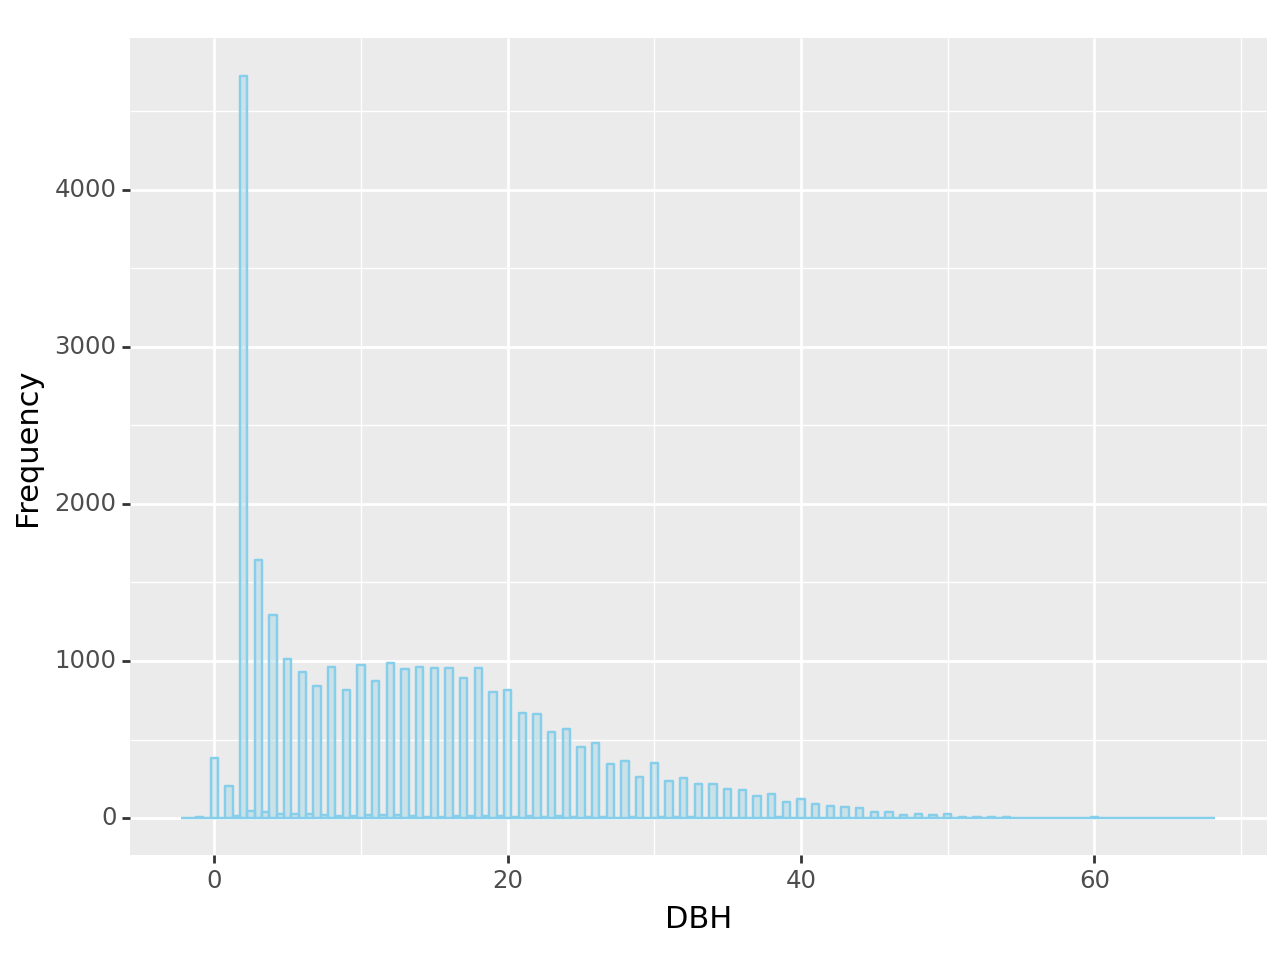

<Figure Size: (640 x 480)>

In [3]:
(
ggplot(df, aes(x='DBH')) +
    geom_histogram(binwidth=0.5, color='skyblue', fill='lightblue', alpha=0.5) +
    labs(x='DBH', y='Frequency', title='')
)

In [4]:
dfAll=df
df = df[~df['Common_Name'].str.contains('Vacant Site', case=False)]
df = df[df['Department'].str.contains('Street Tree', case=False)]
df = df[(df['Last_Editor'].str.lower() != 'alex foreman') | (df['Neighborhood'] == "Fair Haven")]
df = df[df['Longitude'] >= -73]
df = df[df['DBH'] >= 2.1]
df.dropna(subset=['Condition'], inplace=True)


This brings the number of sites from 30504 to 16616, a little more than half.

Next, I thought it would be valuble to see the distribution of the remaining trees in New Haven.

In [5]:
from shapely.geometry import Point
nbhds = nbhds.to_crs(epsg=4326)
#assigning geometry points to the selected tree sites based on lat and long values, then creating a gdf to align with neighborhood polygons
df['points_geometry'] = gpd.GeoDataFrame(geometry=[Point(lon, lat) for lon, lat in zip(df['Longitude'], df['Latitude'])],crs=nbhds.crs)
nbhds_with_counts = df.groupby('Neighborhood').size().reset_index(name='selected_trees')
nbhds = nbhds.merge(nbhds_with_counts, on='Neighborhood', how='left')
nbhds = nbhds.merge(dfAll['Neighborhood'].value_counts(), on='Neighborhood', how='left')
nbhds.rename(columns={'count': 'All_Trees'}, inplace=True)
nbhds['perc_total'] = (nbhds['selected_trees'] / nbhds['All_Trees']) * 100

Notably, wooster square and mill river both have "NA" trees. This is because the original dataset lumps these two neighborhoods together. No inventory has been recently conducted, so there are very few usable datapoints from these two neighborhoods anyway.

In [ ]:
(
  ggplot()
   + geom_map(nbhds, aes(geometry='geometry', fill="selected_trees"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

The number of trees retained after the data cleaning earlier is just over a third of trees in the city. There are clear hotspots, but we know that tree canopy in general is not evenly distributed in reality, so its possible that the distribution we see here is partially due to that.

In [ ]:
(
  ggplot()
   + geom_map(nbhds, aes(geometry='geometry', fill="perc_total"),color=None)
   + scale_fill_gradient(low="#eaf6db", high="#518f02")
)

The second map shows the percent of trees kept, out of all the tree in the original dats set. Most neighborhoods have either most of their trees retained or near none of them retained. This clearly aligns with where URI has been conducting inventories. This map identifies for us which neighborhoods have complete-enough data for this analysis.  I will proceed by retaining only points which belong to neighborhoods with at least 75% of their trees retained. Yes, this number is arbitrary, but sits just below the clear naturally occuring gap in data completeness

In [6]:
nbhds=nbhds[nbhds['perc_total']>75]

# Keep only the rows in df where the value in 'Column_Name' is present in df2
df = df[df['Neighborhood'].isin(nbhds['Neighborhood'].unique())]

Next, I want to set a few different goals.
1. Calculate the percentage of trees under powerlines in each neighborhood
2. calculate the average dbh of trees under powerlines and not under powerlines
3. calculate and vizualize the average health of trees under powerlines and not under powerlines.

Here is a little bit of prep:

In [7]:
# Assigning numerical values for tree health
condition_mapping = {
    'Stump': 0,
    'Standing Dead': 0,
    'Very Poor': 1,
    'Poor': 2,
    'Fair': 3,
    'Good': 4,
    'Excellent': 5
}
df['Condition'] = df['Condition'].replace(condition_mapping)

#creating "wire" and "no wire" subsets.
df_yes = df[df['Wire'] == 'Yes']
df_no = df[df['Wire'] == 'No']

Here are the calculations:

In [8]:

#% of trees under wires in each neighborhood
nbhds = nbhds.merge(df_yes['Neighborhood'].value_counts().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'count': 'Wire_Trees'}, inplace=True)
nbhds['perc_wire'] = (nbhds['Wire_Trees'] / nbhds['selected_trees']) * 100
nbhds.head()

#the average condition of trees under wire or not under wire in each neighborhood
nbhds = nbhds.merge(df_yes.groupby('Neighborhood')['Condition'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'Condition': 'Wire_Condition'}, inplace=True)
nbhds = nbhds.merge(df_no.groupby('Neighborhood')['Condition'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'Condition': 'No_Wire_Condition'}, inplace=True)

#the average DBH of trees under wire or not under wire, excluding dead trees
df_yes_live = df_yes[df_yes['Condition'] != 0]
df_no_live = df_no[df_no['Condition'] != 0]
nbhds = nbhds.merge(df_yes_live.groupby('Neighborhood')['DBH'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'DBH': 'Wire_DBH'}, inplace=True)
nbhds = nbhds.merge(df_no_live.groupby('Neighborhood')['DBH'].mean().reset_index(), on='Neighborhood', how='left')
nbhds.rename(columns={'DBH': 'No_Wire_DBH'}, inplace=True)

nbhds.head()

,OBJECTID,ACRES,Neighborho,Neighborhood,Shape_area,Shape_len,Shape__Are,Shape__Len,UTC_2016,geometry,selected_trees,All_Trees,perc_total,Wire_Trees,perc_wire,Wire_Condition,No_Wire_Condition,Wire_DBH,No_Wire_DBH
0,8,202.58,DWIGHT,Dwight,8.824339e+06,15305.198643,1.454318e+06,6212.201826,.19,"POLYGON ((-72.94142 41.31631, -72.94021 41.315...",871.0,964.0,90.352697,347,39.839265,2.798271,3.085878,14.966770,15.109533
1,15,404.97,NEWHALLVILLE,Newhallville,1.755389e+07,17958.127066,2.894634e+06,7292.602047,.32,"POLYGON ((-72.93959 41.33582, -72.93897 41.335...",1788.0,2154.0,83.008357,739,41.331096,3.276049,3.230696,18.063983,15.815573
2,3,635.72,FAIR-HAVEN,Fair Haven,2.769194e+07,20954.100871,4.563816e+06,8508.526877,.13,"POLYGON ((-72.90118 41.31661, -72.90093 41.316...",2254.0,2757.0,81.755531,1064,47.204969,2.921053,2.966387,14.048250,14.377684
3,22,877.07,ANNEX,Annex,3.820526e+07,27866.216819,6.292540e+06,11311.987361,.19,"POLYGON ((-72.89257 41.30145, -72.89221 41.300...",735.0,906.0,81.125828,362,49.251701,2.809392,3.058981,19.153374,20.803571
4,6,906.48,HILL,Hill,3.948646e+07,33396.076995,6.504362e+06,13552.971679,.16,"POLYGON ((-72.93758 41.30609, -72.93751 41.306...",2279.0,2757.0,82.662314,813,35.673541,2.747847,3.225784,15.173853,15.015412


The percentage of trees under wires ranges from 35.6 and 49.2 in the selected neighborhoods. I am not sure if this reflects differences in the amount of lines overall or not. The trees not under wires have a higher average condition in most neighborhoods, but the difference can be pretty small. Meanwhile, there is not a clear trend in the total DBH of trees under wires; I removed all recently planted trees from consideration, and there are many large trees remaining on the landscape from before the comparatively recent decision to stop planting shade trees under powerlines.

Following this information, I thought it would be valuble to assess condition by DBH, under wires and away from wires.


In [9]:
t_statistic, p_value = stats.ttest_ind(df_yes['Condition'], df_no['Condition'], equal_var=False)  # Assuming unequal variances

# Print results
print("T-Statistic:", t_statistic)
print("P-Value:", p_value)

# Check significance
alpha = 0.05
if p_value < alpha:
    print("The difference in means is statistically significant (reject the null hypothesis)")
else:
    print("There is no statistically significant difference in means (fail to reject the null hypothesis)")

T-Statistic: -5.276616861094148
P-Value: 1.3441527377963248e-07
The difference in means is statistically significant (reject the null hypothesis)


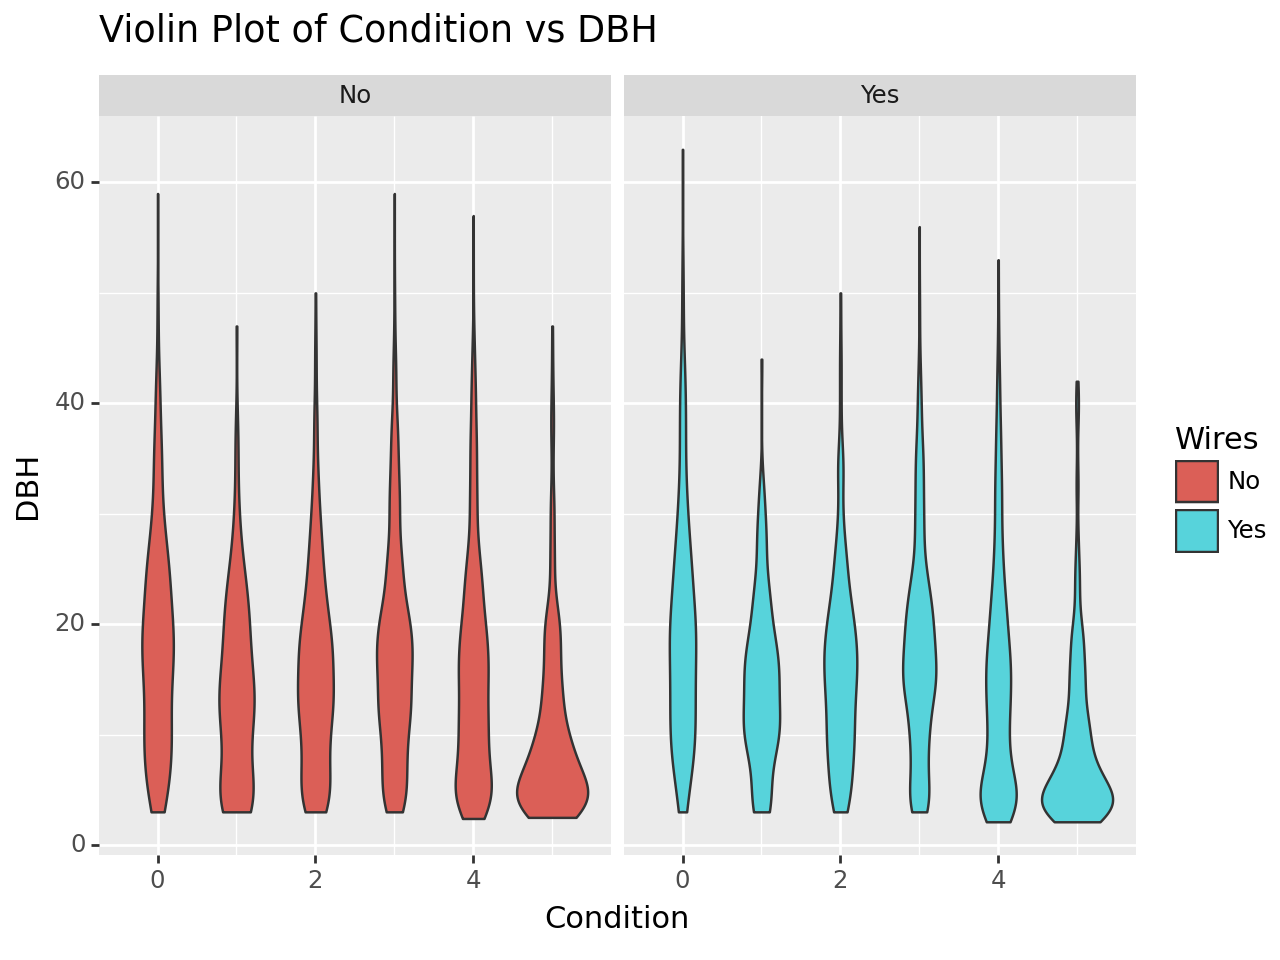

<Figure Size: (640 x 480)>

In [32]:
(ggplot(df, aes(x='Condition', y='DBH', group='Condition',fill='Wire')) +
 geom_violin(position='dodge') +
  facet_wrap('~Wire') +
 labs(x='Condition', y='DBH',fill='Wires') +
 ggtitle('Violin Plot of Condition vs DBH')
)

Differences in the plots are subtle, but they are there! haha